# What demographic variables are associated with higher degrees of altruism? 

**A Thinkful data science project by Raj Prasad, April 2019**

[html version](https://daddyprasad5.github.io/Altruism%20Associations%20Analysis.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Altruism%20Associations%20Analysis.ipynb) - with all the code exposed in an interactive notebook

We have some stereotypes about what kinds of people are more empathetic and altruistic than others, but stereotypes don't always hold-up to scrutiny. Is there any truth to the stereotype of the old curmudgeon yelling "Get a job!" at a homeless man? Are the rich really more self-absorbed and uncaring than those who are less well-off? Do people who value altruism and have strong empathetic feelings actually act on those feelings?  

In this paper, I'll answer these three questions... 

* Do altruistic feeling & action get stronger with age? 
* Do altruistic feeling & action get stronger as income rises?
* Does altruistic action rise with rising strength of altruistic / empathetic feeling?  


## Data Source
I'm choosing to use data from the [GSS Data Explorer](https://gssdataexplorer.norc.org/pages/show?page=gss%2Fabout).  

The General Social Survey (GSS) is a project of the non-partisan and objective research organization NORC at the University of Chicago (NORC).  In their own words, "NORC delivers reliable data and rigorous analysis to guide critical programmatic, business, and policy decisions." The GSS "collects information from the general public in th U.S. on a wide variety of subjects, including attitudes toward social issues, religion, education, jobs and the economy, government and other institutions, politics, and policy issues."  The GSS has been run every two years since 1972.  


## Data Fields

The GSS Data Explorer allows users to extract any elements of interest from the expansive GSS dataset.  The dataset I constructed includes several types of data elements, which were collected in 2002 and 2004: 

* altruistic thoughts & feelings: how the respondent feels about those in need or how the respondent values altruism
* altruistic actions:  how often the respondent donated money or time in the last year
* demographic data: age, income, education, martial status

Here are links to the [data](https://github.com/daddyprasad5/thinkful/blob/master/gss_altruism_data.csv), [descriptions of the variables](https://github.com/daddyprasad5/thinkful/blob/master/gss_variables.csv), and [how the responses were coded](https://github.com/daddyprasad5/thinkful/blob/master/gss_codes.csv). 

## Summary of the Data and Cleaning Procedure

There are a few cleaning procedures required to make the data workable: 

* Replace long variable names with shorter names more conducive to concise code
* Replace text response data to numeric representations
* Drop one weird row where the year value is "Source" - that wasn't a good year for good data :)

The second of these is the most interesting.  There are several scales used in the survey - Strongly Agree to Strongly Disagree, a frequency scale (about how many times have you done X in the past 12 months), and a likeness scale (That statement describes me well -> that statement doesn't describe me well).  All of these are (at least in some rows) recorded as text.  I'll convert all of those to numerics where the higher numbers indicate a more altruistic response.  

Something interesting to note: there is a lot of missing data, where the response was "I don't know" or "Not applicable."  I don't believe that impacts the analysis, but I've taken care to use functions (e.g. nanmean) that accomodate that, and explained where errors appear due to prevalance of all-NaN rows. 

Directly below is the first few lines of the starting dataset, and it's followed by the first few lines of the cleaned data. 


In [4]:
#imports, file load, and print header of raw data

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
%matplotlib inline

#import data from local file - assumed to be in same directory as this workbook
gss_altruism = pd.read_csv('gss_altruism_data.csv')
gss_codes = pd.read_csv('gss_codes.csv')
gss_variables = pd.read_csv('gss_variables.csv')

gss_altruism.head()

,Gss year for this respondent,Respondent income in constant dollars,Family income in constant dollars,Those in need have to take care of themselves,R has given money to a charity,R done volunteer work for a charity,Others misfortunes do not disturb r,R feels protective towards people taken advantage,R does not feel very sorry for people having pro,R have tender feeling for people less fortunate,Highest year of school completed,Age of respondent,Marital status,Respondent id number,Ballot used for interview
0,2002,31618,31618.0,Agree,At least 2 or 3 times in the past year,At least 2 or 3 times in the past year,Does not describe very well,Describes very well,Does not describe very well,Describes very well,14,25,Divorced,1.0,Ballot a
1,2002,80261,160197.0,Strongly agree,Once in the past year,Not at all in the past year,3,3,4,2,16,43,Married,2.0,Ballot c
2,2002,36482,36482.0,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,13,30,Separated,3.0,Ballot a
3,2002,53507,160197.0,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,2,55,Divorced,4.0,Ballot b
4,2002,43779,43779.0,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,7,37,Divorced,5.0,Ballot c


In [5]:
#clean the data


def clean_altruism_df(altr):

    """Cleans up the altruism dataframe.
    This function is very specific to Raj Prasad's altruism paper and is not intended for re-use.
    It accepts as input a dataframe (altr) of very specific structure.
    """

    # replace long variable names with short name
    altr.columns = ["year", "income", "family_income", "care_of_self", "give_money",
                    "give_time", "not_disturbed", "protective", "not_sorry",
                    "tender_feelings", "years_of_school", "age", "marital_status",
                    "id", "ballot"]

    altr.set_index("id", inplace=True)

    # replace text responses with numbers
    agree_disagree = {"No answer": None,
                      "Dont know": None,
                      "Strongly disagree": 1,
                      "Disagree": 2,
                      "Neither agree nor disagree": 3,
                      "Agree": 4,
                      "Strongly agree": 5,
                      "Not applicable": None}

    agree_disagree_inv = {"No answer": None,
                          "Dont know": None,
                          "Strongly disagree": 5,
                          "Disagree": 4,
                          "Neither agree nor disagree": 3,
                          "Agree": 2,
                          "Strongly agree": 1,
                          "Not applicable": None}

    frequency_scale = {"No answer": None,
                       "Dont know": None,
                       "Not at all in the past year": 1,
                       "Once in the past year": 2,
                       "At least 2 or 3 times in the past year": 3,
                       "Once a month": 4,
                       "Once a week": 5,
                       "More than once a week": 6,
                       "Not applicable": None}

    describes_scale = {"No answer": None,
                       "Dont know": None,
                       "Describes very well": 5,
                       "Does not describe very well": 1,
                       "Not applicable": None}

    describes_scale_inv = {5: 1, "4": 2, "3": 3, "2": 4, 1: 5, None: None, np.nan: np.nan}

    school_scale = {"No answer": None,
                    "Don't know": None,
                    "Not applicable": None}

    age_scale = {"No answer": None,
                 "Don't know": None,
                 "89 or older": 89}

    altr["income"] = pd.to_numeric(altr["income"],
                                   errors="coerce", downcast="integer")

    altr["family_income"] = pd.to_numeric(altr["family_income"],
                                          errors="coerce", downcast="integer")

    altr.replace({"care_of_self": agree_disagree}, inplace=True)
    altr["care_of_self"] = pd.to_numeric(altr["care_of_self"],
                                         errors="coerce", downcast="integer")
    altr.replace({"give_money": frequency_scale}, inplace=True)
    altr["give_money"] = pd.to_numeric(altr["give_money"],
                                       errors="coerce", downcast="integer")
    altr.replace({"give_time": frequency_scale}, inplace=True)
    altr["give_time"] = pd.to_numeric(altr["give_time"],
                                      errors="coerce", downcast="integer")
    altr.replace({"not_disturbed": describes_scale}, inplace=True)
    altr["not_disturbed"] = [describes_scale_inv[item]
                             for item in altr["not_disturbed"].values]
    altr["not_disturbed"] = pd.to_numeric(altr["not_disturbed"],
                                          errors="coerce", downcast="integer")
    altr.replace({"protective": describes_scale}, inplace=True)
    altr["protective"] = pd.to_numeric(altr["protective"],
                                       errors="coerce", downcast="integer")
    altr.replace({"not_sorry": describes_scale}, inplace=True)
    altr["not_sorry"] = [describes_scale_inv[item]
                         for item in altr["not_sorry"].values]
    altr["not_sorry"] = pd.to_numeric(altr["not_sorry"],
                                      errors="coerce", downcast="integer")
    altr.replace({"tender_feelings": describes_scale}, inplace=True)
    altr["tender_feelings"] = pd.to_numeric(altr["tender_feelings"],
                                            errors="coerce", downcast="integer")
    altr.replace({"years_of_school": school_scale}, inplace=True)
    altr["years_of_school"] = pd.to_numeric(altr["years_of_school"],
                                            errors="coerce", downcast="integer")
    altr.replace({"age": age_scale}, inplace=True)
    altr["age"] = pd.to_numeric(altr["age"], errors="coerce",
                                downcast="integer")

    # drop weird row where the year == "Source"
    altr = altr[altr.year != "Source"]

    return altr

gss_altruism = clean_altruism_df(gss_altruism)

gss_altruism.head()


,year,income,family_income,care_of_self,give_money,give_time,not_disturbed,protective,not_sorry,tender_feelings,years_of_school,age,marital_status,ballot
id,,,,,,,,,,,,,,
1.0,2002,31618.0,31618.0,4.0,3.0,3.0,5.0,5.0,5.0,5.0,14.0,25.0,Divorced,Ballot a
2.0,2002,80261.0,160197.0,5.0,2.0,1.0,3.0,3.0,2.0,2.0,16.0,43.0,Married,Ballot c
3.0,2002,36482.0,36482.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,30.0,Separated,Ballot a
4.0,2002,53507.0,160197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,55.0,Divorced,Ballot b
5.0,2002,43779.0,43779.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,37.0,Divorced,Ballot c


### Total respondents by year
There are nearly the same number of respondents in each year.  For the rest of this analysis, I am going to treat the respondents as a single pool, as I'm not interested in longitudinal effects. 

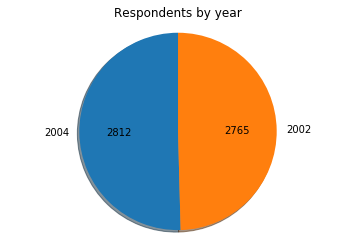

In [6]:
#create a pie chart showing the proportion of responses by year

def total_plot(altr, col_name, title):
    """Plots a pie chart of the the counts (not percentages)
    of the given dataframe with the given title.
    """

    counts = altr[col_name].value_counts()

    tot = counts.sum() / 100.0
    autopct = lambda x: "%d" % round(x * tot)

    fig1, ax1 = plt.subplots()
    ax1.pie(counts.values, labels=counts.index, autopct=autopct,
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

total_plot(gss_altruism, "year", "Respondents by year")

### Demographics 
While the questons I'm pursuing are relevant only to age and income, let's look at those and a few other demographic variables to get a sense of how well our data represents the U.S. population as a whole.  

[Income distribution](https://en.wikipedia.org/wiki/File:Personal_Household_Income_U.png), [age](https://en.wikipedia.org/wiki/File:Uspop.svg),  [education](http://hdr.undp.org/sites/all/themes/hdr_theme/country-notes/USA.pdf), and [marital status](https://www.statista.com/statistics/242030/marital-status-of-the-us-population-by-sex/) all have *roughly* similar shapes to the overall distributions in the US.  Yeah!  That means that there's some hope of extending our conclusions to the U.S. population broadly.  Even more confidence-inspiring is the incredibly detailed [GSS Documentation](http://gss.norc.org/Get-Documentation).  The University of Chicago folks seem to have done a lot to ensure the survey is a good representation of the US.     

To give us even more confidence and, given more time, I would do a t-test of these distributions against 2002 and 2004 census data.  But let's call it good for now. 

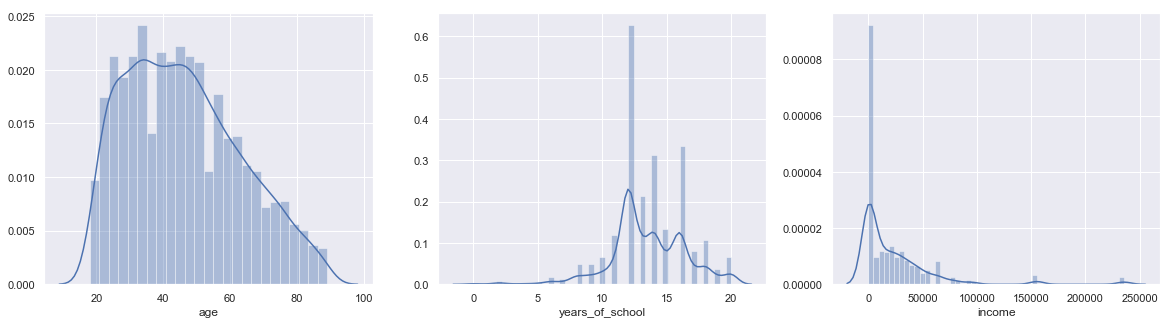

In [81]:
#plot the histograms of the demographic variables

def demog_plots(altr):
    """produces a set of subplots of the demographic data of the given dataframe
    this function is very specific to Raj Prasad's altruism paper and is not meant
    to be re-used.
    """
    sns.set()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1,3,1)
    sns.distplot(altr["age"])
    plt.subplot(1,3,2)
    sns.distplot(altr["years_of_school"])
    plt.subplot(1,3,3)
    sns.distplot(altr["income"])


demog_plots(pd.DataFrame(gss_altruism[["age", "income","years_of_school"]]).dropna())

### Altruistic feeling & action

All of of the altruism measures below are formatted so that the most altruistic response is on the right, and you can see that the responses generally skew to higher altruism.  

This data has the normal biases associated with self-reported, survey data.  Responders will tend to make themselves look better than they are.  And we may have some selection bias, though the direction of that bias is unclear. 

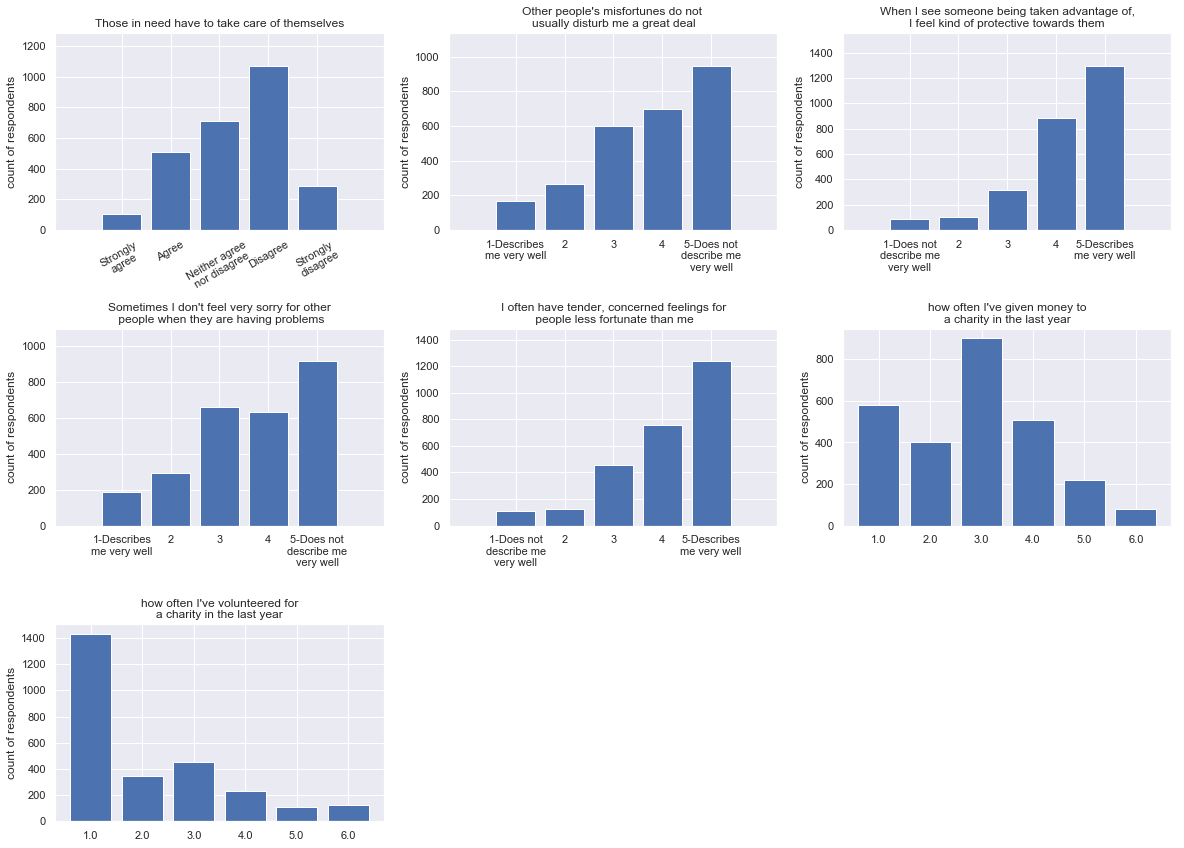

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


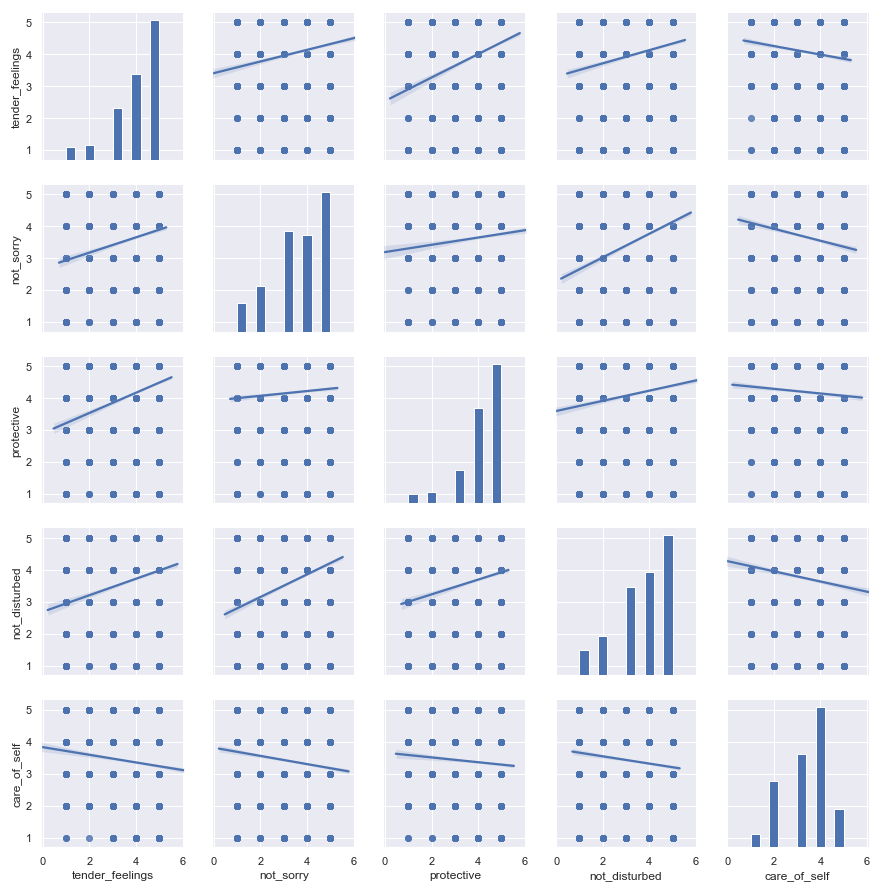

In [87]:
#plot the distributions of the altruism responses

def altruism_plots(gss_altruism):
    """Produces a set of subplots of the altruism responses of the given dataframe.
    This function is very specific to Raj Prasad's altruism paper and is not meant
    to be re-used.
    """

    plt.figure(figsize=(20, 15))
    plt.subplots_adjust(bottom=0.15, hspace=0.5)

    # x-tick labels:
    agree_disagree = ["Strongly\ndisagree", "Disagree", "Neither agree\nnor disagree",
                      "Agree", "Strongly\nagree"]

    agree_disagree_inv = ["Strongly\nagree", "Agree", "Neither agree\nnor disagree",
                          "Disagree", "Strongly\ndisagree"]

    frequency_scale = ["Not at all in\nthe past year", "Once in the\npast year",
                       "At least 2 or 3\ntimes in the\npast year", "Once a month",
                       "Once a week", "More than\nonce a week"]

    describes_scale_inv = ["1-Describes\nme very well", "2", "3", "4",
                           "5-Does not\ndescribe me\nvery well"]

    describes_scale = ["1-Does not\ndescribe me\nvery well", "2", "3", "4",
                       "5-Describes\nme very well"]

    plt.subplot(3, 3, 1)
    care_of_self = gss_altruism["care_of_self"].value_counts().sort_index()
    ind = np.arange(care_of_self.shape[0])
    plt.bar(ind, care_of_self)
    plt.xticks(ind, agree_disagree_inv, rotation=30)
    plt.margins(0.2)
    plt.title("Those in need have to take care of themselves")
    plt.ylabel("count of respondents")

    plt.subplot(3, 3, 2)
    not_disturbed = gss_altruism["not_disturbed"].value_counts().sort_index()
    ind = np.arange(not_disturbed.shape[0])
    plt.bar(ind, not_disturbed)
    plt.xticks(ind, describes_scale_inv)
    plt.margins(0.2)
    plt.title("Other people's misfortunes do not \nusually disturb me a great deal")
    plt.ylabel("count of respondents")

    plt.subplot(3, 3, 3)
    protective = gss_altruism["protective"].value_counts().sort_index()
    ind = np.arange(protective.shape[0])
    plt.bar(ind, protective)
    plt.xticks(ind, describes_scale)
    plt.margins(0.2)
    plt.title("When I see someone being taken advantage of,\nI feel kind of protective towards them")
    plt.ylabel("count of respondents")

    plt.subplot(3, 3, 4)
    not_sorry = gss_altruism["not_sorry"].value_counts().sort_index()
    ind = np.arange(not_sorry.shape[0])
    plt.bar(ind, not_sorry)
    plt.xticks(ind, describes_scale_inv)
    plt.margins(0.2)
    plt.title("Sometimes I don't feel very sorry for other\n people when they are having problems")
    plt.ylabel("count of respondents")

    plt.subplot(3, 3, 5)
    tender_feelings = gss_altruism["tender_feelings"].value_counts().sort_index()
    ind = np.arange(tender_feelings.shape[0])
    plt.bar(ind, tender_feelings)
    plt.xticks(ind, describes_scale)
    plt.margins(0.2)
    plt.title("I often have tender, concerned feelings for\n people less fortunate than me")
    plt.ylabel("count of respondents")

    plt.subplot(3, 3, 6)
    give_money = gss_altruism["give_money"].value_counts().sort_index()
    ind = np.arange(give_money.shape[0])
    plt.bar(ind, give_money)
    plt.xticks(ind, give_money.index)
    plt.title("how often I've given money to\na charity in the last year")
    plt.ylabel("count of respondents")

    plt.subplot(3, 3, 7)
    give_time = gss_altruism["give_time"].value_counts().sort_index()
    ind = np.arange(give_time.shape[0])
    plt.bar(ind, give_time)
    plt.xticks(ind, give_time.index)
    plt.title("how often I've volunteered for\na charity in the last year")
    plt.ylabel("count of respondents")

    plt.show()
    
altruism_plots(gss_altruism)

attitudes = pd.DataFrame(gss_altruism[["tender_feelings", "not_sorry", 
                                       "protective", "not_disturbed", 
                                       "care_of_self"]])

for column in attitudes: attitudes[column] = attitudes[colume].valuecount()

sns.set()



### Introducing the Altruism Index
To make things simpler, I've created an "Altruism Index" that is simply the mean of the altruism answers represented as numbers.  For all of those responses, higher numbers indicate higher altruism.  As one would expect from an index derived additively from many components, the distribution is normal-like.  

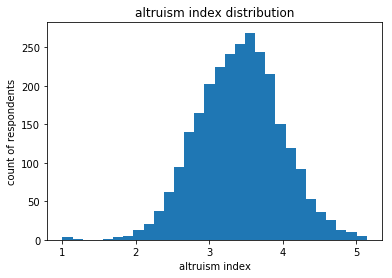

In [16]:
#define and plot a histogram of the altruism index

def plot_alt_index(col):
    """Plots a historgram of the given column
    This function is very specific to Raj Prasad's altruism paper
    and is not meant for reuse
    """

    plt.hist(col, bins=30)
    plt.xlabel("altruism index")
    plt.ylabel("count of respondents")
    plt.title("altruism index distribution")

gss_altruism["alt_index"] = gss_altruism[["care_of_self", "not_disturbed", "give_money",
                                          "give_time", "protective", "not_sorry", 
                                          "tender_feelings"]].apply(np.nanmean, axis = 1)    
    
plot_alt_index(gss_altruism.alt_index)


## Analysis Questions

Our first two questions concern the relationship of age and family income with altruistic feeling and action.  Even if you squint at these scatter plots, it's hard to see any relationship between the index and either age or income.  But that's why God gave us statistics...   

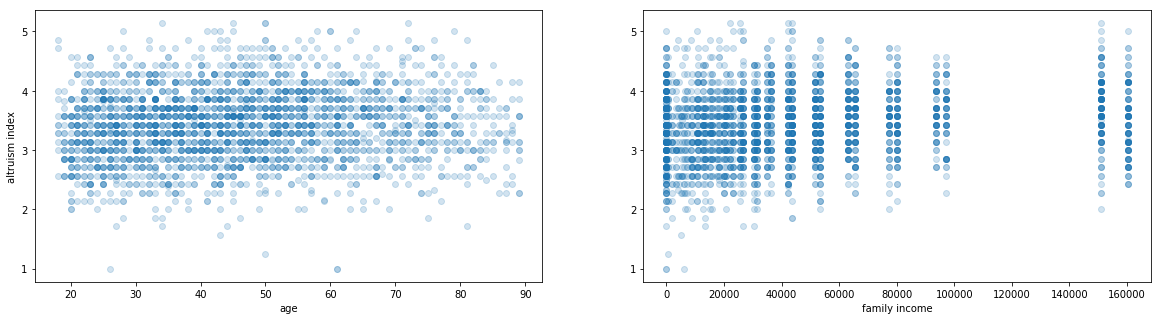

In [7]:
#create scatter plots of age, income vs. altruism index

def alt_index_scatter(altr):
    """Plots a series of scatters
    This function is very specific to Raj Prasad's altruism paper
    and is not meant for reuse
    """

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(x=altr.age, y=altr.alt_index, alpha=0.2)
    plt.xlabel("age")
    plt.ylabel("altruism index")

    plt.subplot(1, 2, 2)
    plt.scatter(x=altr.family_income, y=altr.alt_index, alpha=0.2)
    plt.xlabel("family income")

    plt.show()
    
alt_index_scatter(gss_altruism)

### Do altruistic feeling & action get stronger as income rises?

Contrary to the stereotype of the self-absorbed Mercedes driver, higher income seems to correlate with higher levels of self-reported altruistic feelings and actions.  While the differences in mean altruism index are not high at different income bands, there is a gradual ascent as income grows, and there is a significant difference (p = 1.02e-17) between the less than or equal to 60,000 and greater than 60,000 samples. 

<Figure size 432x288 with 0 Axes>

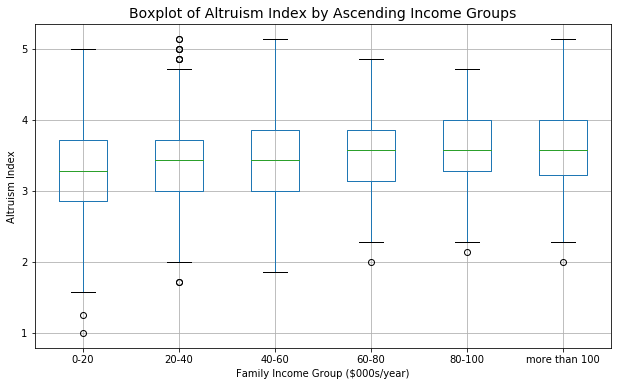

In [8]:
#create boxplots of altruism index for different income groups

def plot_inc_and_altruism(altr):

    plt.figure()
    altr.boxplot(column="alt_index", by="family_income_bin", figsize=(10,6))
    plt.ylabel("Altruism Index")
    plt.xlabel("Family Income Group ($000s/year)")
    plt.suptitle("")
    plt.title("Boxplot of Altruism Index by Ascending Income Groups", fontsize=14)
    plt.show()

gss_altruism['family_income_bin'] = \
    pd.cut(gss_altruism['family_income'], [0, 20000, 40000, 60000, 80000, 100000, np.inf],
           labels=['0-20', '20-40', '40-60','60-80', '80-100','more than 100'])

plot_inc_and_altruism(gss_altruism)

In [9]:
#lets see if the alt_index is statistically different at low (<60k) and high (>60k)

less_than_40 = gss_altruism[gss_altruism.family_income <= 60000]["alt_index"]
greater_than_60 = gss_altruism[gss_altruism.family_income > 60000]["alt_index"]

print(ttest_ind(greater_than_60, less_than_40, equal_var=False, nan_policy='omit'))

Ttest_indResult(statistic=8.680422561649879, pvalue=1.0221989519906683e-17)


### Do altruistic feeling & action get stronger with age?

The stereotype of the old curmedgeon (yelling "get a job" to the homeless man) should be trashed. Yes, altruism takes a  dip in the 60+ group, but that difference is not significant (p = 0.08, compared to the 50-60 set).  In fact, when you compare the +50 to the less than 50 groups, the elders win out (p = 2.25e-05). So think "kindly grandma" more than "curmudgeon."

<Figure size 432x288 with 0 Axes>

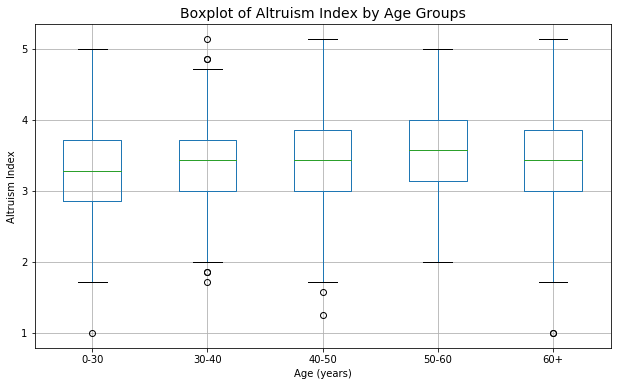

In [10]:
#create boxplots of the altruis index for different age groups

def plot_age_and_altruism(altr):

    plt.figure()
    altr.boxplot(column="alt_index", by="age_bin", figsize=(10,6))
    plt.ylabel("Altruism Index")
    plt.xlabel("Age (years)")
    plt.suptitle("")
    plt.title("Boxplot of Altruism Index by Age Groups", fontsize=14)
    plt.show()

gss_altruism['age_bin'] = \
    pd.cut(gss_altruism['age'], [0, 30, 40, 50, 60, np.inf],
           labels=['0-30', '30-40', '40-50','50-60', '60+'])

plot_age_and_altruism(gss_altruism)

In [11]:
#lets compare different age groups using t-tests

from scipy.stats import ttest_ind

#testing
less_than_50 = gss_altruism[gss_altruism.age < 50]["alt_index"]
bw_50_and_60 = gss_altruism.query('50 < age <= 60')["alt_index"]
greater_than_50 = gss_altruism[gss_altruism.age >= 50]["alt_index"]

print("comparing >60 and 50-60: ")
print(ttest_ind(greater_than_50, bw_50_and_60, equal_var=False, nan_policy='omit'))
print("comparing <50 and 50-60: ")
print(ttest_ind(less_than_50, bw_50_and_60, equal_var=False, nan_policy='omit'))
print("comparing <50 and >50: ")
print(ttest_ind(less_than_50, greater_than_50, equal_var=False, nan_policy='omit'))

comparing >60 and 50-60: 
Ttest_indResult(statistic=-1.7688462144726018, pvalue=0.07729451281310033)
comparing <50 and 50-60: 
Ttest_indResult(statistic=-5.0673275441159085, pvalue=5.205786809214372e-07)
comparing <50 and >50: 
Ttest_indResult(statistic=-4.247441484129012, pvalue=2.2493496863536737e-05)


### Does altruistic action rise with rising strength of altruistic / empathetic feeling? 

There are actually two types of self-assessment in our atruism index: empathetic feelings and altruistic actions.  Do respondents who report high empathetic feeling also report acting on those feelings by donating their time and money? To determine that, I've created two indices - one for empathy and another for altruistic action. 

There's definitely opposite skew here - i.e. respondents seem to report higher empathetic feeling than altruistic action. But that doesn't mean the two are not correlated. Breaking the empathy index into bands shows us a relationship - as empathy rises, so too does altruistic action. And there is indeed a significant difference in altruistic action between low (<=3) and high (>3) empathy index groups (p = 4.92e-08)

(The error below is due to some rows having no valid responses to the altruism questions.  This error can be safely ignored.)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


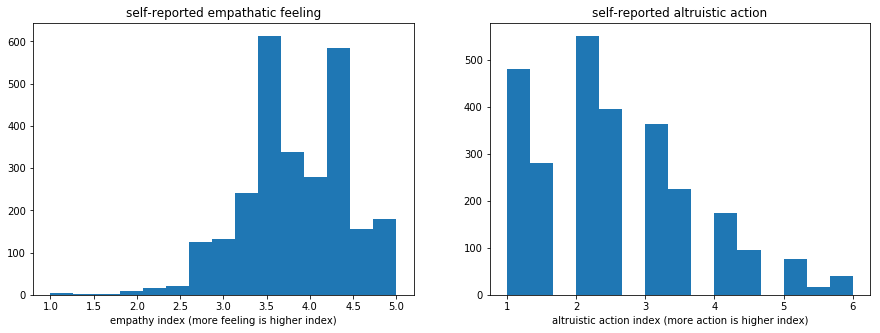

In [17]:
#plot historgram of the empathy and action indices

def plot_emp_action_indices(gss_altruism):
    """This function plots histograms of teh empathy & action
    indices.  It's very peculiar to this notebood and is not 
    meant to be reused."""
    
    gss_altruism["emp_index"] = gss_altruism.apply(lambda row:
                                                   np.nanmean([row['care_of_self'], row['not_disturbed'],
                                                               row['protective'],row['not_sorry'],
                                                               row['tender_feelings']]), axis = 1)

    gss_altruism["alt_action_index"] = gss_altruism.apply(lambda row:
                                                   np.nanmean([row['give_money'],row['give_time']]), axis = 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(gss_altruism["emp_index"], bins=15)
    plt.xlabel("empathy index (more feeling is higher index)")
    plt.title("self-reported empathatic feeling")

    plt.subplot(122)
    plt.hist(gss_altruism["alt_action_index"], bins=15)
    plt.xlabel("altruistic action index (more action is higher index)")
    plt.title("self-reported altruistic action")

    plt.show()

plot_emp_action_indices(gss_altruism)

<Figure size 432x288 with 0 Axes>

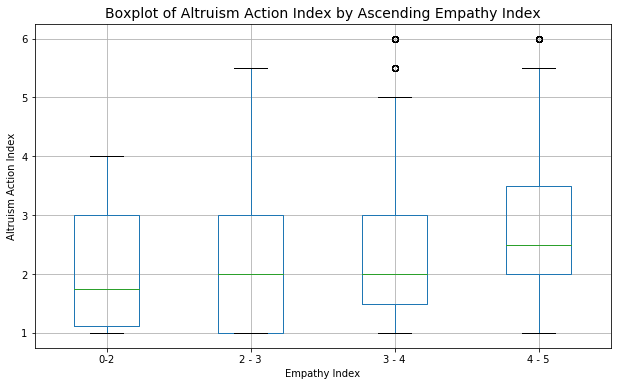

In [13]:
#create boxplots of altruistic action by atruistic feeling group
def alt_action_by_emp(gss_altruism):
    less_than_2 = pd.DataFrame(gss_altruism[gss_altruism.emp_index <= 2]["alt_action_index"])
    bw_2_and_3 = pd.DataFrame(gss_altruism.query('2 < emp_index <= 3')["alt_action_index"])
    bw_3_and_4 = pd.DataFrame(gss_altruism.query('3 < emp_index <= 4')["alt_action_index"])
    bw_4_and_5 = pd.DataFrame(gss_altruism.query('4< emp_index <= 5')["alt_action_index"])
    greater_than_5 = pd.DataFrame(gss_altruism[gss_altruism.emp_index > 5]["alt_action_index"])

    less_than_2["empathy index"] = "0-2"
    bw_2_and_3["empathy index"] = "2 - 3"
    bw_3_and_4["empathy index"] = "3 - 4"
    bw_4_and_5["empathy index"] = "4 - 5"
    greater_than_5["empathy index"] = "5+"

    all_series = pd.concat([less_than_2, bw_2_and_3, bw_3_and_4, bw_4_and_5, greater_than_5])

    plt.figure()
    all_series.boxplot(by="empathy index", figsize=(10, 6))
    plt.ylabel("Altruism Action Index")
    plt.xlabel("Empathy Index")
    plt.suptitle("")
    plt.title("Boxplot of Altruism Action Index by Ascending Empathy Index", fontsize=14)

    plt.show()

alt_action_by_emp(gss_altruism)   

In [14]:
#lets see if the alt_action_index is statistically different at low (<3) and high (>3) empathy indices

from scipy.stats import ttest_ind

less_than_3 = gss_altruism[gss_altruism.emp_index <= 3]["alt_action_index"]
greater_than_3 = gss_altruism[gss_altruism.emp_index > 3]["alt_action_index"]

print(ttest_ind(greater_than_3, less_than_3, equal_var=False, nan_policy='omit'))

Ttest_indResult(statistic=5.559953064662871, pvalue=4.922727524836317e-08)


## Conclusion & Recommendations for Further Research

According to this survey data, our stereotype of the old curmudgeon telling the homeless to "get a job" is false.  As is our stereotype of the rich Mercedes driver too self-absorbed to stop and help someone change a tire.  However, our intuition that empathetic feelings would co-occur with altruistic action is borne out.  

Here are 3 research proposals to explore these findings more deeply: 

* **If we control for income, does altruism still rise with age?** We could determine if there is a significant relationship between age and altruism index within each income band.  Similary, we could control for age and determine if the relationship still holds for income. 
* **What 3rd variable causes might drive the relationship of altruism with age?** While it's possible that the very fact of being older causes the rise in altruism, it is also possible that there are other causes that co-occur with rising age.  We could perform t-tests for number of children, for example. 
* **What is the direction of causation in the relationship of altruistic feeling and altruistic action?** We could design an experiment in which we induce altruistic feeling and then test for presence of altruistic action.  For example, we might give subjects 10 dollars; show different groups different video clips (some inducing altruistic feeling and some neutral); and finally ask the subjects to donate some or all of their 10 dollars to an associated charity. Would those seeing altruistic-feeling-inducing clips donate more? Or to test the inverse, we could assign tasks (some altruistic and some not) to different subject groups, and follow-up with a survey on altruistic feeling.  Will the group participating in an altruistic task score higher in altruistic feeling than those that do some neutral task? 